# Transfer Learning Tutorial

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

These 2 major transfer learning scenarios looks as follows:

- **Finetuning the convnet**: Instead of random initialization, we initialize the network with a pretrained network. Rest of the training looks as usual.

- **ConvNet as fixed feature extractor**: We will freeze the weights of the network except the final fully connected layer, then this layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

plt.ion()   # interactive mode

## 1. Load Data

Problem: Train a model to classify ants and bees. We have about **120** training images each for ants and bees, and **75** validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch.

> 刘尧：训练集120+验证集75，同时两者使用的Transformation不同：**训练集-Data Augmentation and Normalization，验证集-Just Normalization**！

> 刘尧：注意**torchvision.datasets.ImageFolder**(主要进行文件读取和transform)和**torch.utils.data.DataLoader**(主要进行batch,shuffle和并行化设置)的组合使用！

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = './data/hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Visualize a few images

In [5]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(std * inp + mean, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

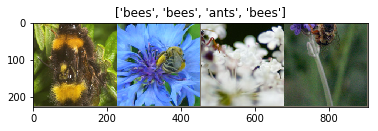

In [6]:
inputs, classes = next(iter(dataloaders['train']))    # Get a batch of training data
out = torchvision.utils.make_grid(inputs)             # Make a grid from batch
imshow(out, title=[class_names[x] for x in classes])

# 2. Training the model

Let's write a general function to train a model. Here, we will illustrate:

- Scheduling the learning rate

- Saving the best model

> 刘尧：每一个训练epoch里都分别有train和val两个phase！手动指定不同phase不同的处理操作
        
   |  |  | train与val流程上的异同 |  |  |  |
  :-: | :-: | :-: | :-: | :-: | :-:
  train | scheduler.step() -> | model.train() -> | set_grad_enabled(True) -> | loss.backward() -> | optimizer.step()
  val |  | model.eval() -> | set_grad_enabled(False) -> |  |  | copy model.state_dict()

> 刘尧：model.state_dict中记录着model的parameters和persistent buffers，使用copy.deepcopy来复制(而非引用)，随后可由model.load_state_dict加载进model

> 刘尧：按val_acc来决定哪个是best model ！？！

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase 
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data, batch by batch
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):  # track history only if in train phase
                    # forward pass
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if train phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'Phase: {phase}  Loss: {epoch_loss: .4f}  Acc: {epoch_acc: .4f}')
            
            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:             # 按val_acc来决定哪个是best model！
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())  # state_dict: Both parameters and persistent buffers
                
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60: .0f}m {time_elapsed % 60: .0f}s')
    print(f'Best val Acc: {best_acc: 4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training  # ?
    model.eval()                   # set model to evaluate mode
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])   # Tensor.cpu(): A copy of this Tensor in CPU memory
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)  # 恢复到原来的mode

# 3. Finetuning the convnet

> 刘尧：获得base model后，默认requires_grad=True，训练时会被训练，即Finetuning；若设置为False，则不会被训练，即fixed feature extractor

In [11]:
# 获得base model，并把其fc层(最后1层)替换为新定义的nn.Linear(随机初始化)
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features    # model_ft.fc.in_features: model_ft的fc层的输入Tensor的features个数，可直接这样使用Module/Layer的参数！
model_ft.fc = nn.Linear(num_ftrs, 2)  # 直接赋值给model_ft.fc即可！
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/liuyao8/.torch/models/resnet18-5c106cde.pth
46827520it [26:27, 29503.24it/s]


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)       # Note that all parameters are being optimized
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)  # Decay LR by a factor of 0.1 every 7 epochs

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Phase: train  Loss:  0.8485  Acc:  0.5902
Phase: val  Loss:  0.2173  Acc:  0.9150
Epoch 1/24
----------
Phase: train  Loss:  0.5827  Acc:  0.8074
Phase: val  Loss:  0.1944  Acc:  0.9281
Epoch 2/24
----------
Phase: train  Loss:  0.5076  Acc:  0.7787
Phase: val  Loss:  0.2378  Acc:  0.9085
Epoch 3/24
----------
Phase: train  Loss:  0.4462  Acc:  0.8033
Phase: val  Loss:  0.4070  Acc:  0.8693
Epoch 4/24
----------
Phase: train  Loss:  0.5169  Acc:  0.8238
Phase: val  Loss:  0.2771  Acc:  0.9216
Epoch 5/24
----------
Phase: train  Loss:  0.4829  Acc:  0.7910
Phase: val  Loss:  0.4202  Acc:  0.8431
Epoch 6/24
----------
Phase: train  Loss:  0.3422  Acc:  0.8648
Phase: val  Loss:  0.2728  Acc:  0.9281
Epoch 7/24
----------
Phase: train  Loss:  0.4525  Acc:  0.8156
Phase: val  Loss:  0.2477  Acc:  0.9020
Epoch 8/24
----------
Phase: train  Loss:  0.2709  Acc:  0.8893
Phase: val  Loss:  0.2545  Acc:  0.9216
Epoch 9/24
----------
Phase: train  Loss:  0.3156  Acc:  0.8730


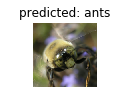

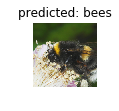

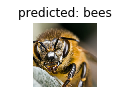

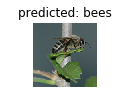

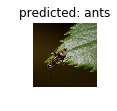

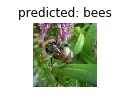

In [23]:
visualize_model(model_ft)

# 4. ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. After setting ***requires_grad=False*** to freeze the parameters, their gradients won't be computed in ***backward()***.

In [24]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False         # 与3.Finetuning the convnet唯一不同之处
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)  # 默认requires_grad=True 
model_conv = model_conv.to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)  # Note that only parameters of final layer are being optimized
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don't need to be computed for most of the network. However, forward does need to be computed.

In [26]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Phase: train  Loss:  0.7418  Acc:  0.6311
Phase: val  Loss:  0.2860  Acc:  0.9020
Epoch 1/24
----------
Phase: train  Loss:  0.4550  Acc:  0.8197
Phase: val  Loss:  0.1796  Acc:  0.9542
Epoch 2/24
----------
Phase: train  Loss:  0.4917  Acc:  0.7869
Phase: val  Loss:  0.1751  Acc:  0.9477
Epoch 3/24
----------
Phase: train  Loss:  0.4155  Acc:  0.8033
Phase: val  Loss:  0.2170  Acc:  0.9542
Epoch 4/24
----------
Phase: train  Loss:  0.5718  Acc:  0.7131
Phase: val  Loss:  0.3401  Acc:  0.8627
Epoch 5/24
----------
Phase: train  Loss:  0.5773  Acc:  0.7664
Phase: val  Loss:  0.1711  Acc:  0.9477
Epoch 6/24
----------
Phase: train  Loss:  0.6488  Acc:  0.7664
Phase: val  Loss:  0.2199  Acc:  0.9281
Epoch 7/24
----------
Phase: train  Loss:  0.3702  Acc:  0.8320
Phase: val  Loss:  0.1718  Acc:  0.9477
Epoch 8/24
----------
Phase: train  Loss:  0.3917  Acc:  0.8402
Phase: val  Loss:  0.1636  Acc:  0.9477
Epoch 9/24
----------
Phase: train  Loss:  0.3612  Acc:  0.8361


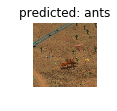

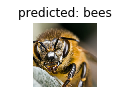

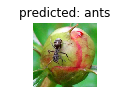

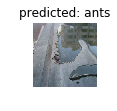

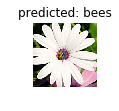

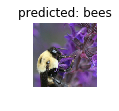

In [27]:
visualize_model(model_conv)
plt.ioff()
plt.show()